# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных
### Импорт библиотек
Импортирую необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor
from tqdm.notebook import tqdm

### Чтение датафрейма и получение основной информации

Открываю файл для чтения

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Вывожу первые строки датафрейма

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Получаю основную информацию о датафрейме

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Вычисление актуальной даты
Сохраняю значение актуальной на будущее

In [5]:
MAX_DATA = data['DateCrawled'].max()
MAX_DATA

'2016-04-07 14:36:58'

### Удаление ненужных столбцов

Проверяю значения в столбце `NumberOfPictures`

In [6]:
data['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

Столбец содержит только нули, поэтому его можно удалить, а вместе с ним и удаляю столбцы, которые не нужны для прогнозирования цены

In [7]:
data = data.drop(columns=[
    'NumberOfPictures',
    'PostalCode',
    'RegistrationMonth',
    'DateCreated',
    'DateCrawled',
    'LastSeen'
])

### Удаление дубликатов
Вывожу количество дубликатов

In [8]:
data.duplicated().sum()

45040

Удаляю дубликаты

In [9]:
data = data.drop_duplicates()

### Обработка пропусков

Вывожу количество пропусков

In [10]:
data.isna().sum()

Price                   0
VehicleType         34559
RegistrationYear        0
Gearbox             17207
Power                   0
Model               18361
Kilometer               0
FuelType            30764
Brand                   0
Repaired            64558
dtype: int64

Проверяю количество значений в столбце `Gearbox`

In [11]:
data['Gearbox'].value_counts()

manual    232774
auto       59348
Name: Gearbox, dtype: int64

Заполняю пропуски и перевожу строки в числа

In [12]:
data['Gearbox'] = data['Gearbox'].apply(lambda x: 0 if x =='auto' else 1)

Проверяю количество значений в столбце `Repaired`

In [13]:
data['Repaired'].value_counts()

no     211328
yes     33443
Name: Repaired, dtype: int64

Заполняю пропуски и перевожу строки в числа

In [14]:
data['Repaired'] = data['Repaired'].apply(lambda x: 0 if x =='yes' else 1)

Остальные данные с пропусками удаляю

In [15]:
before_data = data.shape[0]
data = data.dropna()
print(f"Удалено строк: {before_data - data.shape[0]} ({(100 - (data.shape[0]/before_data) * 100):.2f}%)")

Удалено строк: 59202 (19.14%)


### Очистка выбросов
Для очистки выбросов выведу гистограммы все возможных столбцов

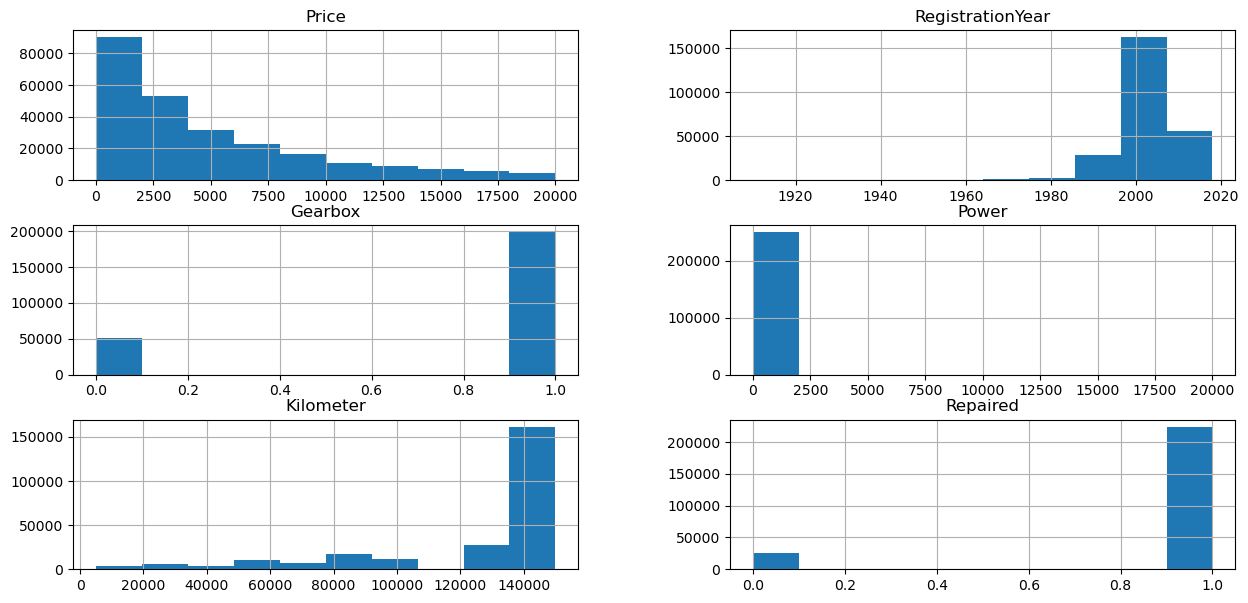

In [16]:
data.hist(figsize=(15, 7));

Далее отдельно выведу гистограмму для мощности

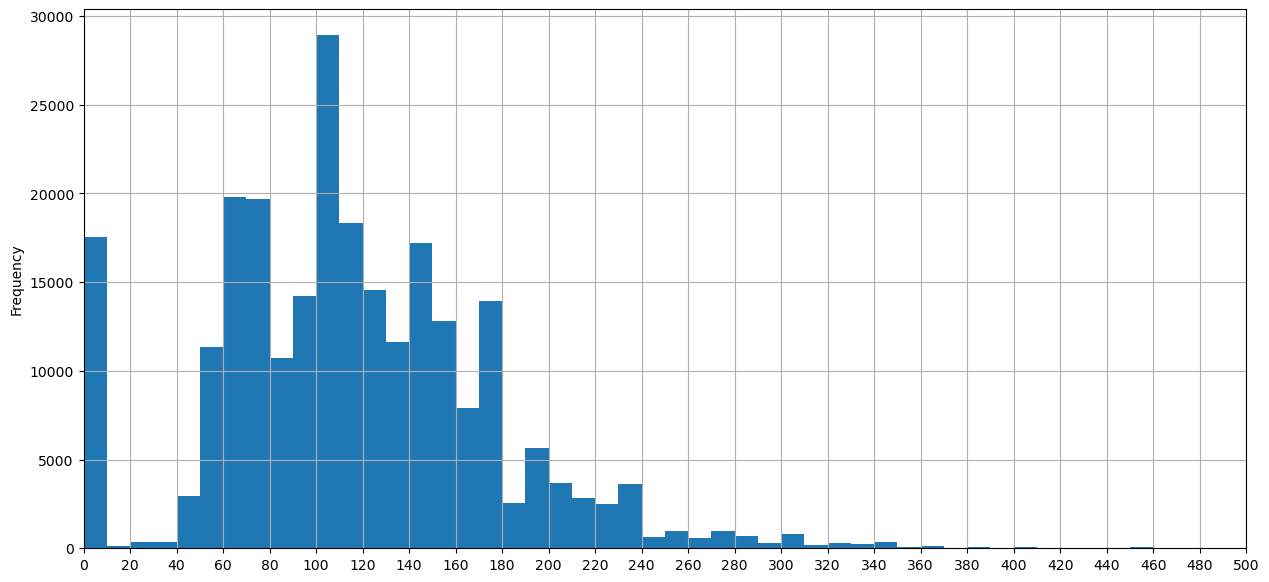

In [17]:
data['Power'].plot.hist(
    bins=2000,
    xticks=[i for i in range(0, 501, 20)],
    xlim=(0,500),
    grid=True,
    figsize=(15,7)
);

Опираясь на гистограмму очищаю выбросы

In [18]:
data = data[data['Power'] >= 40]
data = data[data['Power'] <= 350]

Также вывожу гистограмму для года регистрации

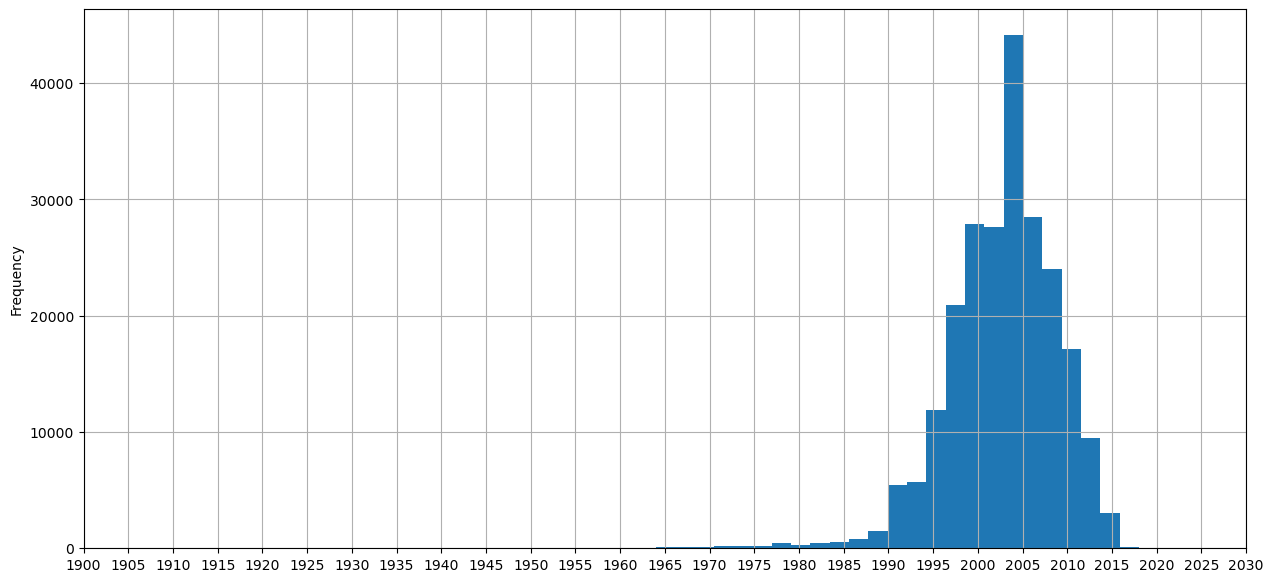

In [19]:
data['RegistrationYear'].plot.hist(
    bins=50,
    grid=True,
    xticks=[i for i in range(1900, 2031, 5)],
    figsize=(15, 7)
);

Гистограмма помогает определить нижний предел. Верхний предел буду определять по переменной `MAX_DATA`, которая хранит в себе дату последней выгрузки данных.

In [20]:
MAX_DATA

'2016-04-07 14:36:58'

Снова очищаю выбросы

In [21]:
data = data[data['RegistrationYear'] >= 1965]
data = data[data['RegistrationYear'] <= 2016]

Столбец с ценой тяжело разобрать на графике гистограммы, однако думаю, что у цены не должно быть нулевого значения

In [22]:
data = data[data['Price'] != 0]

### Подготовка данных к обучению
Делю признаки и целевой признак

In [23]:
features = data.drop(columns=['Price'])
target = data['Price']

Делю данные на тестовую, валидационную и тестовую выборки

In [24]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features,
    target,
    test_size=0.4,
    random_state=1
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid,
    target_valid,
    test_size=0.5,
    random_state=1
)

### Кодирование текстовых признаков
Пишу класс TargetEncoder

In [25]:
# 
class TargetEncoder():
    def fit_transform(self, features, target):
        # В переменных буду хранить среднее значение целевого признака
        self.instruction = {}
        self.mean_target = target.mean()
        full_data = pd.concat([features, target], axis=1)
        for column in features.columns:
            self.instruction[column] = full_data.groupby(column)['Price'].mean()
            features[column] = features[column].apply(lambda x: self.instruction[column].get(x))
        return features
    
    
    def transform(self, features):
        for column in features.columns:
            features[column] = features[column].apply(lambda x: self.instruction[column].get(x))
        # Если данных не было в тренировачной выборке, то они заполняются просто средним значением
        return features.fillna(self.mean_target)

Методом TargetEncoder кодирую признаки

In [26]:
encoding_columns = [
    'VehicleType',
    'Model',
    'FuelType',
    'Brand'
]
encoder = TargetEncoder()
encode_data_train = encoder.fit_transform(features_train.loc[:, encoding_columns], target_train)
encode_data_valid = encoder.transform(features_valid.loc[:, encoding_columns])
encode_data_test = encoder.transform(features_test.loc[:, encoding_columns])

### Масштабирование данных
Провожу масштабирование данных

In [27]:
scale_columns = [
    'RegistrationYear',
    'Power',
    'Kilometer'
]
scaler = StandardScaler()
scale_data_train = scaler.fit_transform(features_train.loc[:, scale_columns])
scale_data_valid = scaler.transform(features_valid.loc[:, scale_columns])
scale_data_test = scaler.transform(features_test.loc[:, scale_columns])

In [28]:
features_train = np.concatenate([
    scale_data_train,
    encode_data_train,
    np.array(features_train.drop(columns=scale_columns + encoding_columns))
], axis = 1)
features_valid = np.concatenate([
    scale_data_valid,
    encode_data_valid,
    np.array(features_valid.drop(columns=scale_columns + encoding_columns))
], axis = 1)
features_test = np.concatenate([
    scale_data_test,
    encode_data_test,
    np.array(features_test.drop(columns=scale_columns + encoding_columns))
], axis = 1)

**Вывод раздела.** В данном разделе были произведены следующие действия:
+ загружены необходимые библиотеки;
+ загружены данные;
+ выведена основная информация о данных;
+ убраны лишние столбцы;
+ обработаны пропуски;
+ очищены выбросы;
+ произведено преобразование дат;
+ получены дамми признаки;
+ данные подготовлены к обучению;
+ произведено масштабирование данных.

Данные действия должны увеличить точность предсказания моделей машинного обучения.

## Обучение моделей
### Линейная регрессия
Проверяю модель линейной регрессии

In [29]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)
mean_squared_error(target_valid, model.predict(features_valid)) ** 0.5

CPU times: total: 109 ms
Wall time: 39 ms


2697.5472243496965

### LGBMRegressor
Проверяю LGBMRegressor

In [30]:
%%time
best_score = 2500
best_est = 0
best_num_leaves = 0
best_learning_rate = 0
for learning_rate in tqdm(range(1, 6), position=0, desc="learning_rate", leave=False):
    for est in tqdm(range(500, 2001, 500), position=1, desc="est", leave=False):
        model = lgb.LGBMRegressor(
            learning_rate=0.1 * learning_rate,
            n_estimators=est,
            n_jobs=-1,
            random_state=1
        )
        model.fit(features_train, target_train)
        score = mean_squared_error(target_valid, model.predict(features_valid)) ** 0.5
        if score < best_score:
            best_score = score
            best_est = est
            best_learning_rate = 0.1 * learning_rate

learning_rate:   0%|          | 0/5 [00:00<?, ?it/s]

est:   0%|          | 0/4 [00:00<?, ?it/s]

est:   0%|          | 0/4 [00:00<?, ?it/s]

est:   0%|          | 0/4 [00:00<?, ?it/s]

est:   0%|          | 0/4 [00:00<?, ?it/s]

est:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: total: 4min 55s
Wall time: 51.5 s


Вывожу наилучшие параметры для модели LGBMRegressor

In [31]:
print(best_score)
print(best_est)
print(best_learning_rate)

1554.323016154402
2000
0.1


### CatBoostRegressor
Проверяю CatBoostRegressor

In [32]:
%%time
best_score = 2500
best_learning_rate = 0
best_iterations = 0
for iterations in tqdm(range(500, 2001, 500), position=0, desc="iterations", leave=False):
    for learning_rate in tqdm(range(1, 6), position=1, desc="learning_rate", leave=False):
        model = CatBoostRegressor(
            learning_rate=0.1 * learning_rate,
            iterations=iterations,
            random_state=1,
            verbose=0,
            task_type="GPU"
        )
        model.fit(features_train, target_train)
        score = mean_squared_error(target_valid, model.predict(features_valid)) ** 0.5
        if score < best_score:
            best_score = score
            best_learning_rate = 0.1 * learning_rate
            best_iterations = iterations

iterations:   0%|          | 0/4 [00:00<?, ?it/s]

learning_rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning_rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning_rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning_rate:   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 2min 44s
Wall time: 1min 42s


Вывожу наилучшие параметры для модели CatBoostRegressor

In [33]:
print(best_score)
print(best_learning_rate)
print(best_iterations)

1561.816515900329
0.2
2000


**Вывод раздела.** В данном разделе был произведён перебор гиперпараметров разных моделей машинного обучения, чтобы найти лучшие гиперпараметры для каждой из моделей на валидационной выборке.

## Анализ моделей
### Линейная регрессия
Оцениваю время работы и точность линейной регрессии на тестовых данных

**Время обучения**

In [34]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: total: 62.5 ms
Wall time: 33.5 ms


LinearRegression()

**Время предсказания**

In [35]:
%%time
predicted = model.predict(features_test)

CPU times: total: 15.6 ms
Wall time: 1 ms


**Оценка модели**

In [36]:
mean_squared_error(target_test, predicted) ** 0.5

2711.670096154414

### LGBMRegressor
Оцениваю время работы и точность LGBMRegressor на тестовых данных

**Время обучения**

In [37]:
%%time
model = lgb.LGBMRegressor(
    learning_rate=0.05,
    n_estimators=1500,
    n_jobs=-1,
    random_state=1
)
model.fit(features_train, target_train)

CPU times: total: 18 s
Wall time: 3.17 s


LGBMRegressor(learning_rate=0.05, n_estimators=1500, random_state=1)

**Время предсказания**

In [38]:
%%time
predicted = model.predict(features_test)

CPU times: total: 3.3 s
Wall time: 599 ms


**Оценка модели**

In [39]:
mean_squared_error(target_test, predicted) ** 0.5

1560.0586561062466

### CatBoostRegressor
Оцениваю время работы и точность CatBoostRegressor на тестовых данных

**Время обучения**

In [40]:
%%time
model = CatBoostRegressor(
    learning_rate=0.4,
    iterations=2000,
    random_state=1,
    verbose=0,
    task_type="GPU"
)
model.fit(features_train, target_train)

CPU times: total: 13 s
Wall time: 8.32 s


**Время предсказания**

In [41]:
%%time
predicted = model.predict(features_test)

CPU times: total: 109 ms
Wall time: 30.5 ms


**Оценка модели**

In [42]:
mean_squared_error(target_test, predicted) ** 0.5

1574.626781513214

### Итоговая таблица

Данные анализа записаны в итоговую таблицу
<table style="float: left; width: 100%; margin: 20px 0"> 
    <tr>
        <th>Этап/Модель</th>
        <th>Линейная регрессия</th>
        <th>LGBMRegressor</th>
        <th>CatBoostRegressor</th>
    </tr>
    <tr>
        <td><b>Время обучения, сек</b></td>
        <td>0.033</td>
        <td>3.17</td>
        <td>8.32</td>
    </tr>
    <tr>
        <td><b>Время предсказания, сек</b></td>
        <td>0.001</td>
        <td>0.599</td>
        <td>0.03</td>
    </tr>
    <tr>
        <td><b>Оценка модели, RMSE</b></td>
        <td>2711.67</td>
        <td>1560.06</td>
        <td>1574.63</td>
    </tr>
</table>

**Вывод раздела.** В данном разделе был проведён анализ скорости работы и качества моделей. На основе анализа можно прийти к следующим заключениям:
+ линейная регрессия обладает самой быстрой скоростью обучения и предсказания данных, однако в то же время у неё наихудшая точность;
+ LGBMRegressor точнее остальных моделей;
+ Точность CatBoostRegressor чуть ниже LGBMRegressor, однако эта модель намного быстрее предсказывает данные.

Подводя итоги, можно сказать, что CatBoostRegressor и LGBMRegressor схожи по точности, однако скорость предсказания у CatBoostRegressor в разы выше. Скорость обучения влияет на решение не так сильно, потому что обучение происходит реже, чем предсказания.

**Вывод.** Целью данной работы было обучить и выбрать наилучшую модель для предсказания цены на авто. Критерии, которые важны были заказчику:
+ качество предсказания;
+ время обучения модели;
+ время предсказания модели.

Для выполнения работы были проведены следующие действия:
+ подготовлены и обработаны данные;
+ обучены модели машинного обчуения;
+ проведён анализ моделей машинного обучения и выбрана наилучшая модель.

Лучшая модель по итогам данного анализа - CatBoostRegressor.